<a href="https://colab.research.google.com/github/ManjunathD620/Sentiment_Analysis_with_RNN/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

In [ ]:
from google.colab import files

!mkdir -p ~/.kaggle
files.upload()

!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -U -q kaggle

In [ ]:
# !kaggle datasets download -d kazanova/sentiment140
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 19% 5.00M/25.7M [00:00<00:00, 39.8MB/s]
100% 25.7M/25.7M [00:00<00:00, 140MB/s] 


In [ ]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
import pandas as pd

df = pd.read_csv("/content/IMDB Dataset.csv",encoding="utf-8")


In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
print(df["sentiment"].unique(),df["sentiment"].isnull().sum())

['positive' 'negative'] 0


In [ ]:
y = df["sentiment"].tolist()
y_int = []

for item in y:
  if(item=="positive"):
    y_int.append(1)
  else:
    y_int.append(0)

y = y_int

In [ ]:
y = np.array(y)

In [ ]:
print(y.shape)
print("catagories=",np.unique(y))

(50000,)
catagories= [0 1]


In [ ]:
x = df["review"].tolist()
print(len(x),type(x[0]))

50000 <class 'str'>


In [ ]:
!pip install bs4

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup as bs
import re
import string

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')

sw_nltk = stopwords.words('english')

refined = []
for item in x:

  words = [word.lower() for word in item.split() if word.lower() not in sw_nltk]
  removed_stop = " ".join(words)
  removed_html = bs(removed_stop).get_text()
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  removed_url = url_pattern.sub(r'',removed_html)
  removed_punctuation = removed_url.translate(str.maketrans('','',string.punctuation))
  
  lemmatized_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in removed_punctuation.split()] 
  lemmatized_sent = " ".join(lemmatized_words)

  refined.append(lemmatized_sent)

x = refined

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
x[10]

'phil alien one quirky film humour base around oddness everything rather actual punchlinesat first odd pretty funny movie progress find joke oddness funny anymoreits low budget film thats never problem itself pretty interest character eventually lose interesti imagine film would appeal stoner currently partakingfor something similar better try brother another planet'

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.70,test_size=0.30, random_state=101)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=5000, oov_token="<oov>")
tokenizer.fit_on_texts(x_train)


In [ ]:
word_index = tokenizer.word_index
for index, (key, value) in enumerate(word_index.items()):
    print(key, value)
    if(index >50):
      break

<oov> 1
film 2
movie 3
one 4
make 5
like 6
see 7
get 8
time 9
good 10
character 11
watch 12
go 13
even 14
would 15
think 16
really 17
story 18
show 19
it 20
look 21
much 22
say 23
well 24
know 25
end 26
people 27
great 28
bad 29
also 30
give 31
take 32
play 33
first 34
love 35
act 36
come 37
find 38
movies 39
could 40
way 41
seem 42
work 43
many 44
want 45
plot 46
two 47
never 48
be 49
try 50
little 51
best 52


In [ ]:
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences,padding="post",maxlen=100,truncating="post")

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences,padding="post",maxlen=100,truncating="post")

In [ ]:
print(train_padded.shape,y_train.shape,test_padded.shape,y_test.shape)

(35000, 100) (35000,) (15000, 100) (15000,)


In [ ]:
import tensorflow as tf

def builder(hp):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(5000,hp.Int("embedding_layer", min_value=16, max_value=64, step=6), input_length=100),
      tf.keras.layers.LSTM(20),
      tf.keras.layers.Dense(hp.Int("first_dense_layer", min_value=64, max_value=128, step=32), activation='relu'),
      tf.keras.layers.Dense(hp.Int("seond_dense_layer", min_value=128, max_value=256, step=64), activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model


In [ ]:
!pip install keras-tuner -q

     |████████████████████████████████| 133 kB 6.8 MB/s 


In [ ]:
from keras_tuner import RandomSearch
tuner = RandomSearch(
    builder,
    objective="accuracy",
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory="models",
    project_name="cnn",
)

In [ ]:
tuner.search(train_padded[0:2000], y_train[0:2000], epochs=1, validation_data=(test_padded[0:200], y_test[0:200]))

Trial 47 Complete [00h 00m 08s]
accuracy: 0.5130000114440918

Best accuracy So Far: 0.5224999785423279
Total elapsed time: 00h 05m 50s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
print(best_hps.values)

{'embedding_layer': 64, 'first_dense_layer': 96, 'seond_dense_layer': 128}


In [ ]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test), verbose=1)

Epoch 1/10
1094/1094 [==============================] - 51s 45ms/step - loss: 0.4484 - accuracy: 0.7765 - val_loss: 0.3399 - val_accuracy: 0.8521
Epoch 2/10
1094/1094 [==============================] - 49s 44ms/step - loss: 0.3032 - accuracy: 0.8755 - val_loss: 0.3303 - val_accuracy: 0.8577
Epoch 3/10
1094/1094 [==============================] - 49s 45ms/step - loss: 0.2579 - accuracy: 0.8958 - val_loss: 0.3660 - val_accuracy: 0.8537
Epoch 4/10
1094/1094 [==============================] - 49s 44ms/step - loss: 0.2175 - accuracy: 0.9137 - val_loss: 0.4134 - val_accuracy: 0.8474
Epoch 5/10
1094/1094 [==============================] - 48s 44ms/step - loss: 0.1756 - accuracy: 0.9335 - val_loss: 0.4364 - val_accuracy: 0.8389
Epoch 6/10
1094/1094 [==============================] - 48s 44ms/step - loss: 0.1452 - accuracy: 0.9472 - val_loss: 0.4721 - val_accuracy: 0.8355
Epoch 7/10
1094/1094 [==============================] - 49s 45ms/step - loss: 0.1209 - accuracy: 0.9578 - val_loss: 0.4721 -

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 64)           320000    
                                                                 
 lstm_1 (LSTM)               (None, 20)                6800      
                                                                 
 dense_3 (Dense)             (None, 96)                2016      
                                                                 
 dense_4 (Dense)             (None, 128)               12416     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 341,361
Trainable params: 341,361
Non-trainable params: 0
_________________________________________________________________


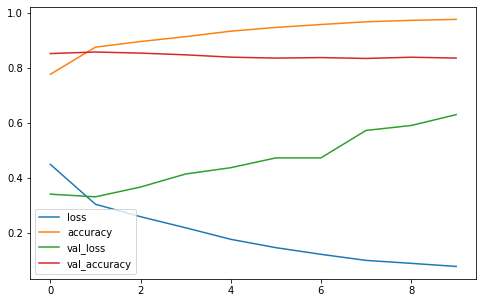

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))

In [ ]:
loss,accuracy = model.evaluate(test_padded,y_test)
print("acuracy =",accuracy)

469/469 [==============================] - 4s 9ms/step - loss: 0.6296 - accuracy: 0.8356
acuracy = 0.8356000185012817


In [ ]:
model.save("sentiment.h5")

In [ ]:
import random
r = random.randint(0,len(test_padded)-1)
pred = model.predict(np.expand_dims(test_padded[r],axis=0))
print("predicted negative" if int(np.round(pred[0]))==0 else "predicted positive")
print("actual negative" if y_test[r]==0 else "actual positive")
print(x_test[r])

predicted negative
actual negative
movie must absolute worst movie ever see sister boyfriend go rent zodiac 2007 get one accident think joke actual movie terrible wait get scary never do movie actual facts real zodiac killer filmmakers clearly even bother research anything kill like name decide write script nothing true name upset realize movie sooner try like something every movie hate movies ever except one could give star definitely would have 1 10


In [ ]:

import pickle

with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [ ]:
from keras.models import load_model

model = load_model("sentiment.h5")

In [ ]:
import pickle

tokenizer = None
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup as bs
import re
import string

x = [input()]

lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
nltk.download('wordnet')

sw_nltk = stopwords.words('english')

refined = []
for item in x:

  words = [word.lower() for word in item.split() if word.lower() not in sw_nltk]
  removed_stop = " ".join(words)
  removed_html = bs(removed_stop).get_text()
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  removed_url = url_pattern.sub(r'',removed_html)
  removed_punctuation = removed_url.translate(str.maketrans('','',string.punctuation))
  
  lemmatized_words = [lemmatizer.lemmatize(w, wordnet.VERB) for w in removed_punctuation.split()] 
  lemmatized_sent = " ".join(lemmatized_words)

  refined.append(lemmatized_sent)

xt = refined

waste of time
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
xt_sequences = tokenizer.texts_to_sequences(xt)
xt_padded = pad_sequences(xt_sequences,padding="post",maxlen=100,truncating="post")

In [ ]:
xt_padded.shape

(1, 100)

In [ ]:
pred = model.predict(xt_padded)

In [ ]:
import numpy as np

print("predicted negative" if int(np.round(pred[0]))==0 else "predicted positive")

predicted negative
